<a href="https://colab.research.google.com/github/rak1307/PotholeDetection/blob/main/Pothole_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -q datasets transformers evaluate timm albumentations

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
#import/load dataset
from datasets import load_dataset
dataset = load_dataset("manot/pothole-segmentation", name = "full")
dataset["train"][515]

{'image_id': 352,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 'width': 640,
 'height': 640,
 'objects': {'id': [921],
  'area': [270110],
  'bbox': [[8.0, 72.0, 628.6959838867188, 429.635986328125]],
  'category': [0]}}

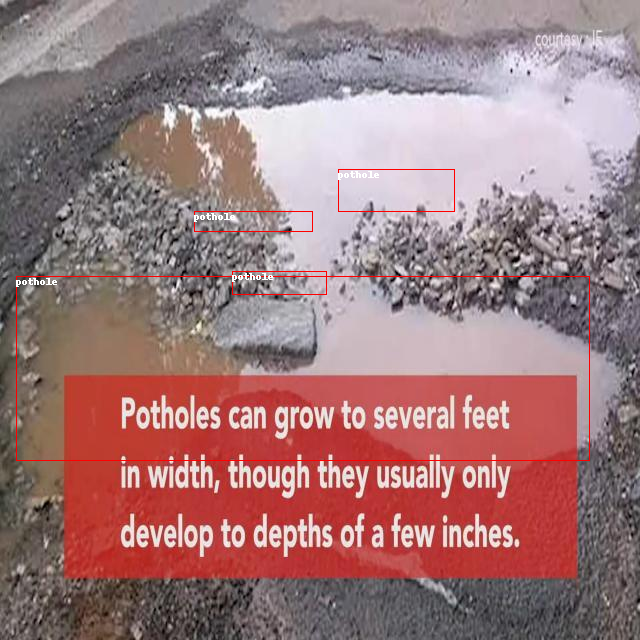

In [4]:
import numpy as np
import os
from PIL import Image, ImageDraw

image = dataset["train"][515]["image"]
annotations = dataset["train"][1]["objects"]
draw = ImageDraw.Draw(image)

categories = dataset["train"].features["objects"].feature["category"].names

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

In [5]:
remove_idx = [277, 428, 146, 255, 41, 104, 111, 60, 208, 403, 4, 422, 417, 169, 178, 117, 510, 160, 363, 294, 330, 244,
             222, 391, 220, 400, 156, 437, 573, 266, 138, 514, 156, 225, 540, 340, 250, 470, 121, 170, 200, 294, 388, 391,
             38, 10, 73, 362, 22, 65, 135, 493, 69, 442, 530, 101, 543, 55, 92, 353]
keep = [i for i in range(len(dataset["train"])) if i not in remove_idx]
dataset["train"] = dataset["train"].select(keep)

In [6]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [7]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [8]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)
    return annotations

In [9]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []

    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [10]:
dataset["train"] = dataset["train"].with_transform(transform_aug_ann)
dataset["train"][515]

{'pixel_values': tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  1.8379,  1.8379,  1.8379],
          [ 2.2489,  2.2489,  2.2489,  ...,  1.8379,  1.8379,  1.8379],
          [ 2.2489,  2.2489,  2.2489,  ...,  1.8379,  1.8379,  1.8379],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[ 2.4286,  2.4286,  2.4286,  ...,  1.8158,  1.8158,  1.8158],
          [ 2.4286,  2.4286,  2.4286,  ...,  1.8158,  1.8158,  1.8158],
          [ 2.4286,  2.4286,  2.4286,  ...,  1.8158,  1.8158,  1.8158],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[ 2.6400,  2.6400,  2.6400,  ...,  1.8905,  1.8905,  1.8905],
          [ 

In [11]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [12]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes= True,
)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([4, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
!pip install transformers[torch]

In [14]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_dataset",
    per_device_train_batch_size=8,
    num_train_epochs=10,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub= True,
)

In [15]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=dataset["train"],
    tokenizer=image_processor,
)

trainer.train()

/content/detr-resnet-50_finetuned_dataset is already a clone of https://huggingface.co/rice-rice/detr-resnet-50_finetuned_dataset. Make sure you pull the latest changes with `repo.git_pull()`.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
50,4.914900
100,2.948400
150,2.307300
200,2.095800
250,1.940800
300,1.838400
350,1.787400
400,1.730400
450,1.693900
500,1.585100


TrainOutput(global_step=660, training_loss=2.1246204087228486, metrics={'train_runtime': 1096.7162, 'train_samples_per_second': 4.787, 'train_steps_per_second': 0.602, 'total_flos': 2.50896635136e+18, 'train_loss': 2.1246204087228486, 'epoch': 10.0})

In [16]:
trainer.push_to_hub()

Upload file pytorch_model.bin:   0%|          | 1.00/159M [00:00<?, ?B/s]

Upload file runs/Aug03_17-18-35_69afca622e8e/events.out.tfevents.1691083126.69afca622e8e.3116.0:   0%|        …

To https://huggingface.co/rice-rice/detr-resnet-50_finetuned_dataset
   bfd4244..ea0b713  main -> main

   bfd4244..ea0b713  main -> main

To https://huggingface.co/rice-rice/detr-resnet-50_finetuned_dataset
   ea0b713..897cf1a  main -> main

   ea0b713..897cf1a  main -> main



'https://huggingface.co/rice-rice/detr-resnet-50_finetuned_dataset/commit/ea0b7133460ee111617903c7fe37822f117e482f'

In [17]:
import json



def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)

    return annotations



def save_dataset_annotation_file_images(dataset):
    output_json = {}
    path_output_dataset = f"{os.getcwd()}/dataset/"

    if not os.path.exists(path_output_dataset):
        os.makedirs(path_output_dataset)

    path_anno = os.path.join(path_output_dataset, "dataset_ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in dataset:
        ann = val_formatted_anns(example["image_id"], example["objects"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(dataset["image"], dataset["image_id"]):
        path_img = os.path.join(path_output_dataset, f"{img_id}.png")
        im.save(path_img)

    return path_output_dataset, path_anno

In [19]:
import torchvision


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, image_processor, ann_file):
        super().__init__(img_folder, ann_file)
        self.image_processor = image_processor

    def __getitem__(self, idx):

        img, target = super(CocoDetection, self).__getitem__(idx)


        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.image_processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return {"pixel_values": pixel_values, "labels": target}


im_processor = AutoImageProcessor.from_pretrained("rice-rice/detr-resnet-50_finetuned_dataset")

path_output_dataset, path_anno = save_dataset_annotation_file_images(dataset["test"])
test_ds_coco_format = CocoDetection(path_output_dataset, im_processor, path_anno)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [20]:
import evaluate
from tqdm import tqdm

model = AutoModelForObjectDetection.from_pretrained("rice-rice/detr-resnet-50_finetuned_dataset")
module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]


        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = im_processor.post_process(outputs, orig_target_sizes)

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()
print(results)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 10/10 [07:14<00:00, 43.41s/it]


Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.020
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.135
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.104
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.166
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [60]:
from transformers import pipeline
import requests

url = "https://datasets-server.huggingface.co/assets/manot/pothole-segmentation/--/full/test/37/image/image.jpg"
image = Image.open(requests.get(url, stream=True).raw)

obj_detector = pipeline("object-detection", model="rice-rice/detr-resnet-50_finetuned_dataset")
obj_detector(image)

[]

In [61]:
image_processor = AutoImageProcessor.from_pretrained("rice-rice/detr-resnet-50_finetuned_dataset")
model = AutoModelForObjectDetection.from_pretrained("rice-rice/detr-resnet-50_finetuned_dataset")

with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.3, target_sizes=target_sizes)[0]
    #print("got here")

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected potholes with confidence 0.364 at location [84.16, 225.78, 449.86, 405.91]


<ipython-input-62-4ecc3b9b756f>:12: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text)


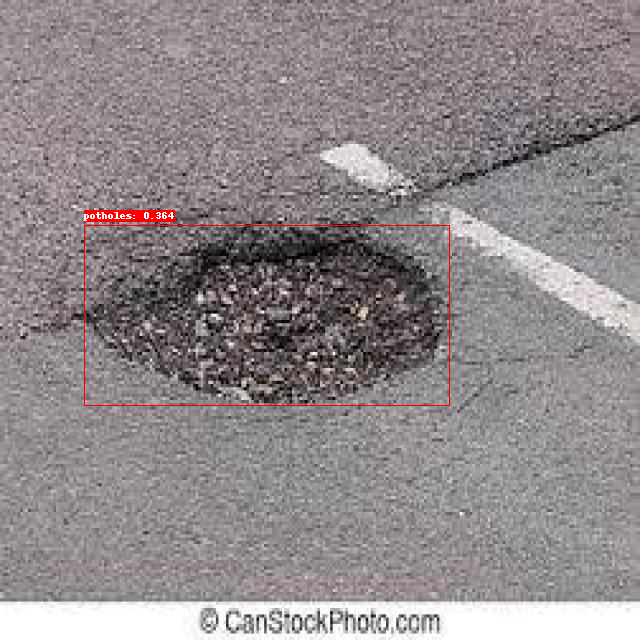

In [62]:
draw = ImageDraw.Draw(image)
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    class_label = model.config.id2label[label.item()]
    confidence = round(score.item(), 3)


    draw.rectangle(box, outline="red")


    text = f"{class_label}: {confidence}"
    text_width, text_height = draw.textsize(text)
    text_location = [box[0], box[1] - text_height - 4]
    draw.rectangle([text_location[0], text_location[1], text_location[0] + text_width, text_location[1] + text_height], fill="red")
    draw.text(text_location, text, fill="white")

image